# Projeto 14: Rede Neural Convolucional - Gatos e Cachorros

## Etapa 1: Importação das Bibliotecas

In [1]:
!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 51.6MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
import torch
import zipfile

from torch import nn, optim
from torchvision import datasets, transforms

In [3]:
torch.manual_seed(123)

## Etapa 2: Construção do modelo

In [4]:
cls = nn.Sequential(
    # output = (input - filter + 1) / stride
    nn.Conv2d(in_channels = 3, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=32),
    # (64 - 3 + 1) / 1 = 62x62
    nn.MaxPool2d(kernel_size=2),
    # 31x31
    nn.Conv2d(32,32,3),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    # (31 - 3 + 1) / 1 = 29x29
    nn.MaxPool2d(kernel_size=2),
    # 14x14
    nn.Flatten(),
    # 6272 -> 128 -> 128 -> 1
    nn.Linear(in_features=14*14*32, out_features=128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128,128),
    nn.Linear(128,1),
    nn.Sigmoid()
)

In [5]:
criterion = nn.BCELoss()
optimizer = optim.Adam(cls.parameters())

## Etapa 3: Base de dados

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
path = '/content/gdrive/MyDrive/dataset.zip'
zip_obj = zipfile.ZipFile(file=path, mode ='r')
zip_obj.extractall('./')
zip_obj.close()

In [8]:
path_train = '/content/dataset/training_set'
path_test = '/content/dataset/test_set'

In [9]:
transform_train = transforms.Compose(
    [
     transforms.Resize([64,64]),
     transforms.RandomHorizontalFlip(),
     transforms.RandomAffine(degrees=7, translate=(0,0.07), shear=0.2, scale=(1,1.2)),
     transforms.ToTensor()
    ]
)

In [10]:
transform_test = transforms.Compose(
    [
     transforms.Resize([64,64]),
     transforms.ToTensor()
    ]
)

In [11]:
train_data = datasets.ImageFolder(path_train, transform=transform_train)
train_data

Dataset ImageFolder
    Number of datapoints: 4000
    Root location: /content/dataset/training_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=(-7, 7), translate=(0, 0.07), scale=(1, 1.2), shear=(-0.2, 0.2))
               ToTensor()
           )

In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

In [13]:
test_data = datasets.ImageFolder(path_test, transform=transform_test)

In [14]:
test_data

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: /content/dataset/test_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [15]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

## Etapa 4: Treinamento do modelo

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [17]:
cls.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten()
  (9): Linear(in_features=6272, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): Linear(in_features=128, out_features=1, bias=True)
  (14): Sigmoid()
)

In [18]:
def train_loop(loader, epoch):

  running_loss = 0.
  running_acc = 0.

  for i, data in enumerate(loader):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = cls(inputs)

    loss = criterion(outputs, labels.float().view(*outputs.shape))
    loss.backward()

    optimizer.step()
    running_loss += loss.item()

    predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
    equals = predicted == labels.view(*predicted.shape)

    acc = torch.mean(equals.float())
    running_acc += acc

    print('\rÉPOCA {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}' \
          .format(epoch + 1, i + 1, len(loader), loss, acc), end='\r')
  
  print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}\n' \
        .format(epoch + 1, running_loss / len(loader), running_acc / len(loader)))

In [19]:
for epoch in range(10):
  print('TREINANDO...')
  train_loop(train_loader, epoch)
  
  cls.eval()
  print('\nVALIDANDO...')
  train_loop(test_loader, epoch)

  cls.train()

TREINANDO...
ÉPOCA   1 FINALIZADA: perda 0.64341 - precisão 0.63825


VALIDANDO...
ÉPOCA   1 FINALIZADA: perda 0.65934 - precisão 0.61328

TREINANDO...
ÉPOCA   2 FINALIZADA: perda 0.58675 - precisão 0.69375


VALIDANDO...
ÉPOCA   2 FINALIZADA: perda 0.56917 - precisão 0.68945

TREINANDO...
ÉPOCA   3 FINALIZADA: perda 0.55342 - precisão 0.71400


VALIDANDO...
ÉPOCA   3 FINALIZADA: perda 0.49549 - precisão 0.75977

TREINANDO...
ÉPOCA   4 FINALIZADA: perda 0.54380 - precisão 0.72225


VALIDANDO...
ÉPOCA   4 FINALIZADA: perda 0.46054 - precisão 0.79004

TREINANDO...
ÉPOCA   5 FINALIZADA: perda 0.50754 - precisão 0.74625


VALIDANDO...
ÉPOCA   5 FINALIZADA: perda 0.35867 - precisão 0.84277

TREINANDO...
ÉPOCA   6 FINALIZADA: perda 0.48271 - precisão 0.76175


VALIDANDO...
ÉPOCA   6 FINALIZADA: perda 0.25921 - precisão 0.88965

TREINANDO...
ÉPOCA   7 FINALIZADA: perda 0.47243 - precisão 0.77625


VALIDANDO...
ÉPOCA   7 FINALIZADA: perda 0.23114 - precisão 0.91895

TREINANDO...
ÉPOCA   8 FINA

## Etapa 5: Avaliação do modelo

In [27]:
def cls_img(fname):
  from PIL import Image
  import matplotlib.pyplot as plt
  img_test = Image.open(path_test + '/' + fname)
  plt.imshow(img_test)

  import numpy as np
  img_test = img_test.resize((64, 64))
  img_test = np.array(img_test.getdata()).reshape(*img_test.size, 3)
  img_test = img_test / 255
  img_test = img_test.transpose(2,0,1)
  img_test = torch.tensor(img_test, dtype=torch.float).view(-1, *img_test.shape)

  cls.eval()
  img_test = img_test.to(device)
  output = cls.forward(img_test)

  if output > 0.5:
    output = 1
  else:
    output = 0
  print('Previsão: ', output)

  idx_cls = {value: key for key, value in test_data.class_to_idx.items()}

  return idx_cls[output]


Previsão:  1


'gato'

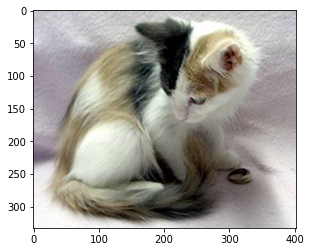

In [28]:
img = '/gato/cat.3500.jpg'
cls_img(img)

Previsão:  0


'cachorro'

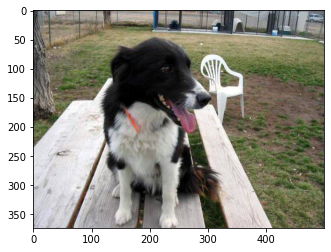

In [30]:
img = '/cachorro/dog.3502.jpg'
cls_img(img)